In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [3]:
"""
Read in train and test as Pandas DataFrames
"""
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## EDA

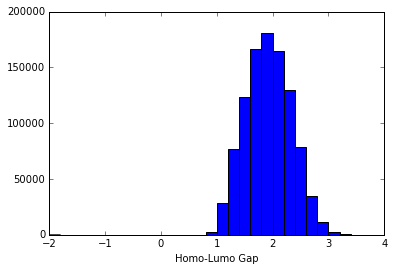

In [141]:
plt.hist(df_train.gap, bins=np.arange(-2, 4, 0.2))
plt.xlabel('Homo-Lumo Gap')
plt.show()

In [147]:
df_train = df_train.drop(df_train[df_train.gap<0].index)

In [148]:
df_train.shape

(999997, 258)

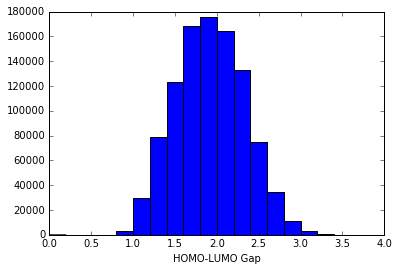

In [150]:
plt.hist(df_train.gap, bins=np.arange(0, 4, 0.2))
plt.xlabel('HOMO-LUMO Gap')
plt.show()

## Cross-validation on small sample

In [45]:
df_sample_train, df_sample_test = train_test_split(df_train, train_size=0.01, test_size=0.1)
print df_sample_train.shape
print df_sample_test.shape
df_sample_train.head()
df_sample_train.to_csv('Data/df_sample_train.csv')
df_sample_test.to_csv('Data/df_sample_test.csv')

(10000, 258)
(100000, 258)


In [46]:
y_train = df_sample_train.gap.values
y_test = df_sample_test.gap.values

In [47]:
df_sample_all = pd.concat((df_sample_train, df_sample_test), axis=0)

In [ ]:
ngram_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), lowercase=False)
ngram_vectorizer.fit(df_sample_all.smiles)

In [88]:
def to_ngrams(X, n_feats=None):
    X = ngram_vectorizer.transform(X.smiles)
    return X

In [41]:
def smiles_to_fingerprint (smiles, n_bits): 
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, n_bits)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    return fp_arr

In [43]:
def to_fingerprints(X, n_bits):
    fps = X.smiles.apply(lambda x: smiles_to_fingerprint(x, n_bits)).tolist()
    X_fps = np.ndarray((len(fps), n_bits))
    for i in range (len(fps)):
        X_fps[i] = fps[i]
    return X_fps

In [107]:
def cv_optimize(reg,params, X, y,  n_folds=3):
    gs = GridSearchCV(reg, param_grid=params, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs.best_estimator_,gs.best_params_, gs.best_score_, gs.grid_scores_

In [122]:
#ridge_grid_scores.sort(key = lambda x: x.params.alpha)
#for model in ridge_grid_scores:
    #print model.parameters['alpha']
def plot_grid_scores(grid_scores, param_name, log=True):
    params =  [model.parameters[param_name] for model in grid_scores]
    scores = [-model.mean_validation_score for model in grid_scores]
    plt.plot(params, scores)
    if log:
        plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.show()

In [103]:
X_train_ng = to_ngrams(df_sample_train)
X_test_ng = to_ngrams(df_sample_test)
X_train_fp2048 = to_fingerprints(df_sample_train, 2048)
X_test_fp2048 = to_fingerprints(df_sample_test, 2048)
X_train_fp4096 = to_fingerprints(df_sample_train, 4096)
X_test_fp4096 = to_fingerprints(df_sample_test, 4096)

In [114]:
def do_regression (model_name, model, X_train, X_test, params, y_train=y_train, y_test=y_test):
    best_estimator, best_params, best_score, grid_scores =  cv_optimize(model, params, X_train, y_train)
    print "Validation RMSE: " + str(-best_score)
    best_estimator.fit (X_train, y_train)
    test_rmse = mean_squared_error(best_estimator.predict(X_test),y_test)
    print "Test RMSE: " + str(test_rmse)
    return {'model': model_name, 'cv_rmse': -best_score, 'test_rmse':test_rmse, 'grid_scores':grid_scores, 'best_params': best_params}     
    

## Ridge Regression

### NGrams

In [81]:
params = {'alpha': [ 1e-6, 1e-5, 1e-4, 1e-3, 0.1,0.2,0.5, 1]}
result = do_regression('Ridge-Ngrams', Ridge(), X_train_ng, X_test_ng, params)

Validation RMSE: 0.0372984013679
Test RMSE: 0.0362822930191


In [82]:
results = pd.DataFrame(columns= ['model', 'cv_rmse', 'test_rmse','grid_scores','best_params'])
results = results.append(result, ignore_index=True)
results

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}


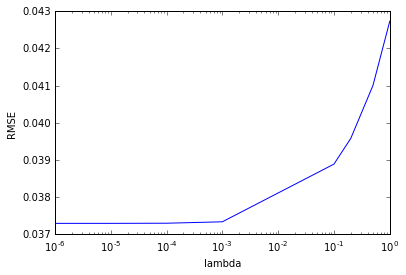

In [84]:
plot_grid_scores(result['grid_scores'])

### Morgan Fingerprints

Validation RMSE: 0.0301618910175
Test RMSE: 0.0362822930191


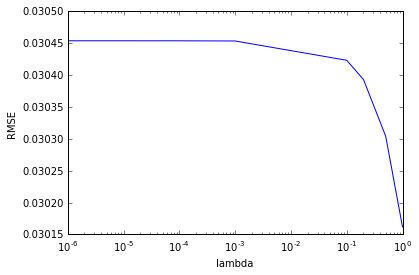

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}
1,Ridge-Morgans-2048,0.030162,0.028413,"[({u'alpha': 1e-06}, -0.0304537287038, [-0.031...",{u'alpha': 1}


In [99]:
result = do_regression('Ridge-Morgans-2048', Ridge(),X_train_fp2048, X_test_fp2048, params)
results = results.append(result, ignore_index=True)
plot_grid_scores(result['grid_scores'])
results

Validation RMSE: 0.0345557882171
Test RMSE: 0.0362822930191


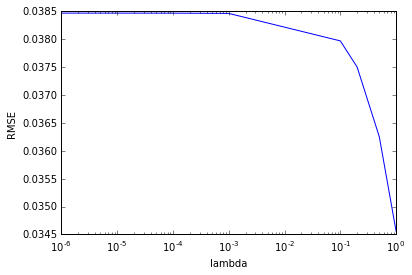

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}
1,Ridge-Morgans-2048,0.030162,0.028413,"[({u'alpha': 1e-06}, -0.0304537287038, [-0.031...",{u'alpha': 1}
2,Ridge-Morgans-4096,0.034556,0.029111,"[({u'alpha': 1e-06}, -0.0384670367704, [-0.038...",{u'alpha': 1}


In [100]:
result = do_regression('Ridge-Morgans-4096', Ridge(),X_train_fp4096, X_test_fp4096, params)
results = results.append(result, ignore_index=True)
plot_grid_scores(result['grid_scores'])
results

## Random Forests

Validation RMSE: 0.0350908143976
Test RMSE: 0.031595654754


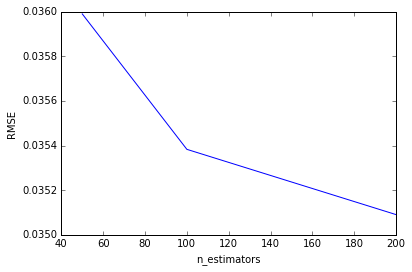

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}
1,Ridge-Morgans-2048,0.030162,0.028413,"[({u'alpha': 1e-06}, -0.0304537287038, [-0.031...",{u'alpha': 1}
2,Ridge-Morgans-4096,0.034556,0.029111,"[({u'alpha': 1e-06}, -0.0384670367704, [-0.038...",{u'alpha': 1}
3,Lasso-Ngrams,0.037600,0.036743,"[({u'alpha': 1e-06}, -0.0376004612751, [-0.038...",{u'alpha': 1e-06}
4,Forest-Ngrams,0.061432,0.058233,"[({u'n_estimators': 20}, -0.066028767, [-0.060...",{u'n_estimators': 100}
5,Forest-Ngrams,0.035091,0.031596,"[({u'n_estimators': 50}, -0.0359900951925, [-0...",{u'n_estimators': 200}


In [120]:
params = {'n_estimators': [50,100,200]}
result = do_regression('Forest-Ngrams', RandomForestRegressor(n_jobs=-1), X_train_ng, X_test_ng, params)
results = results.append(result, ignore_index=True)
plot_grid_scores(result['grid_scores'], 'n_estimators', log=True)
results

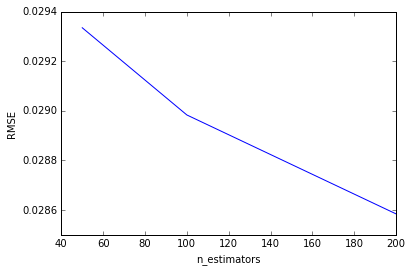

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}
1,Ridge-Morgans-2048,0.030162,0.028413,"[({u'alpha': 1e-06}, -0.0304537287038, [-0.031...",{u'alpha': 1}
2,Ridge-Morgans-4096,0.034556,0.029111,"[({u'alpha': 1e-06}, -0.0384670367704, [-0.038...",{u'alpha': 1}
3,Lasso-Ngrams,0.037600,0.036743,"[({u'alpha': 1e-06}, -0.0376004612751, [-0.038...",{u'alpha': 1e-06}
4,Forest-Ngrams,0.061432,0.058233,"[({u'n_estimators': 20}, -0.066028767, [-0.060...",{u'n_estimators': 100}
5,Forest-Ngrams,0.035091,0.031596,"[({u'n_estimators': 50}, -0.0359900951925, [-0...",{u'n_estimators': 200}
6,Forest-Morgans-2048,0.028585,0.288087,"[({u'n_estimators': 50}, -0.0293351976174, [-0...",{u'n_estimators': 200}


In [123]:
result = do_regression('Forest-Morgans-2048', RandomForestRegressor(n_jobs=-1), X_train_fp2048, X_test_fp2048, params)
results = results.append(result, ignore_index=True)
plot_grid_scores(result['grid_scores'], 'n_estimators', log=False)
results

In [127]:
results = results.drop(results.index[4])

In [135]:
results

,model,cv_rmse,test_rmse,grid_scores,best_params
0,Ridge-Ngrams,0.037298,0.036282,"[({u'alpha': 1e-06}, -0.0372984013679, [-0.038...",{u'alpha': 1e-06}
1,Ridge-Morgans-2048,0.030162,0.028413,"[({u'alpha': 1e-06}, -0.0304537287038, [-0.031...",{u'alpha': 1}
2,Ridge-Morgans-4096,0.034556,0.029111,"[({u'alpha': 1e-06}, -0.0384670367704, [-0.038...",{u'alpha': 1}
3,Lasso-Ngrams,0.037600,0.036743,"[({u'alpha': 1e-06}, -0.0376004612751, [-0.038...",{u'alpha': 1e-06}
5,Forest-Ngrams,0.035091,0.031596,"[({u'n_estimators': 50}, -0.0359900951925, [-0...",{u'n_estimators': 200}
6,Forest-Morgans-2048,0.028585,0.288087,"[({u'n_estimators': 50}, -0.0293351976174, [-0...",{u'n_estimators': 200}
